# Optimize an MZI in the time domain to perform the XOR on two subsequent bits

## Imports

In [1]:
import torch
import numpy as np
import photontorch as pt
import matplotlib.pyplot as plt

from ipywidgets import interact
from tqdm.notebook import trange

## Parameters & Settings

In [2]:
c = 299792458.0 #[m/s] speed of light
Rb = 20e9 #[1/s] bitrate
Rs = 320e9 #[1/s] samplerate
fc = 20e9 #[1/s] cutoff frequency for bit generation
wl0 = 1550e-9 #[m] center wavelength
neff = 2.34 #[1] effective index
ng = 3.4 #[1] group index
N = 100 #[1] number of bits per bit stream
B = 10 #[1] number of bit streams in training batch
Str, Sva, Ste = (1, 2, 3) #[1] train seed, validation seed, test seed
Lr = (1/Rb) * (c/ng) #[m] reference length (distance the signal travels during one bit period)
device = torch.device("cpu") # default device used
torch.set_default_dtype(torch.float32) # default dtype used
torch.manual_seed(123) # pytorch seed
np.random.seed(42) # numpy seed

## Bit generator

In [3]:
class BitGenerator(np.random.RandomState):
    def __call__(self, N, B=1):
        """ generate a bit sequence
        
        Args:
            N: number of bits per sequence
            B: number of sequences in batch
        """
        bits = self.rand(N,B) > 0.5
        return bits

## Bit operations

In [4]:
def COPY(bits):
    return bits.copy()
def XOR(bits):
    return (np.concatenate([bits, np.zeros_like(bits[-1:])], 0) ^ np.concatenate([np.zeros_like(bits[:1]), bits], 0))[:-1]
def AND(bits):
    return (np.concatenate([bits, np.zeros_like(bits[-1:])], 0) & np.concatenate([np.zeros_like(bits[:1]), bits], 0))[:-1]

TARGET = XOR

## Generate Streams

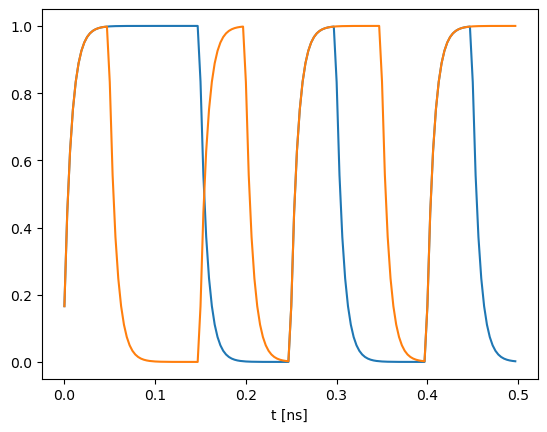

In [5]:
bits = BitGenerator(seed=23)(10)
streamgen = pt.BitStreamGenerator(bitrate=Rb, samplerate=Rs, cutoff_frequency=fc, device=device)
stream = streamgen(bits)
target = streamgen(TARGET(bits))
t = np.arange(stream.shape[0])*(1/Rs)
plt.plot(1e9*t, stream.data.cpu().numpy())
plt.plot(1e9*t, target.data.cpu().numpy())
plt.xlabel("t [ns]")
plt.show()

In [6]:
# train streams
trbits = BitGenerator(seed=Str)(N, B) # N bits per train stream, B train streams per batch.
trstream = streamgen(trbits)
trtarget = streamgen(TARGET(trbits))**2
t = np.arange(trstream.shape[0])*(1/Rs)

# validation streams
vabits = BitGenerator(seed=Sva)(N, 1) # N bits per validation stream, 1 validation stream per batch.
vastream = streamgen(vabits)
vatarget = streamgen(TARGET(vabits))**2

# test streams
tebits = BitGenerator(seed=Ste)(N*B, 1) # N*B bits per teststream
testream = streamgen(tebits)
tetarget = streamgen(TARGET(tebits))**2

## Simple MZI Circuit

In [7]:
class Circuit(pt.Network):
    def __init__(self):
        super().__init__()
        self.src = pt.Source()
        self.det = pt.Detector()
        self.trm1 = self.trm2 = pt.Term()
        self.dc1 = pt.DirectionalCoupler(coupling=np.random.rand(), trainable=True)
        self.dc2 = pt.DirectionalCoupler(coupling=np.random.rand(), trainable=True)
        self.wg1 = pt.Waveguide(length=2*Lr, phase=2*np.pi*np.random.rand(), loss=0.0, trainable=True)
        self.wg2 = pt.Waveguide(length=1*Lr, phase=2*np.pi*np.random.rand(), loss=0.0, trainable=True)
        self.link("trm1:0", "3:dc1:2", "0:wg1:1", "3:dc2:2", "0:trm2")
        self.link( "src:0", "0:dc1:1", "0:wg2:1", "0:dc2:1", "0:det")

## Training

initial plot (to find a good latency)

In [8]:
nw = Circuit()
with pt.Environment(t=t):
    detected = nw(source=vastream.rename("t", "b"))[:,0,0,:] # lower dimensional sources should have named dimensions
    
mse = pt.MSELoss(latency=0.0, warmup=0.0, bitrate=Rb, samplerate=Rs)
@interact(latency=(0,3,0.1))
def _(latency=1.0):
    mse.plot(vastream, label="input")
    mse.plot(vatarget, label="target")
    mse.plot(detected, latency=latency, label="detected")
    plt.legend()
    plt.xlim(0,1)
    plt.show()

interactive(children=(FloatSlider(value=1.0, description='latency', max=3.0), Output()), _dom_classes=('widget…

In [9]:
mse = pt.MSELoss(latency=1.0, warmup=0.0, bitrate=Rb, samplerate=Rs)
ber = pt.BERLoss(latency=1.0, threshold=0.5, warmup=0.0, bitrate=Rb, samplerate=Rs)

In [10]:
scale = torch.tensor(1.0, requires_grad=True)
bias = torch.tensor(0.0, requires_grad=True)
optim = torch.optim.Adam([scale, bias, *nw.parameters()], lr=0.1)
range_ = trange(40)
with pt.Environment(t=t, enable_grad=True):
    for i in range_:
        optim.zero_grad()
        trdet = nw(source=trstream.rename("t", "b"))[:,0,0,:]*scale + bias
        loss = mse(trdet, trtarget)
        loss.backward()
        optim.step()
        range_.set_postfix(loss=loss.item(), ber=ber(trdet, trtarget))

  0%|          | 0/40 [00:00<?, ?it/s]

Let's take a look at the final result:

ber:	0.0
mse:	0.05174911394715309


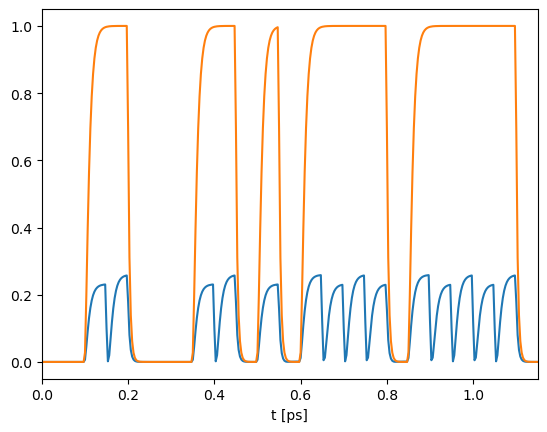

In [11]:
with pt.Environment(t=t):
    vadet = nw(source=vastream.rename("t", "b"))[:,0,0,:]
    ber_err = ber(vadet, vatarget, threshold=float((0.5-bias)/scale))
    mse_err = mse(scale*vadet+bias, vatarget)

    print(f"ber:\t{ber_err}")
    print(f"mse:\t{mse_err.item()}")

    mse.plot(vadet)
    mse.plot(vatarget, latency=0.0)
    plt.xlim(-0,1.15)
    plt.xlabel("t [ps]")
    plt.show()